# Bayesian Aggregation and Neural Architectures
In the Bayesian framework, model learning extends beyond deterministic optimization to encompass distributions over model parameters. By leveraging the PAC-Bayesian theory, this paradigm provides robust generalization guarantees by evaluating the expected performance across the posterior distribution of models. Specifically, for a given model $f_\theta(x)$ parameterized by $\theta$, and its posterior distribution $Q(\theta)$, the aggregated function is defined as:

$$
F_Q(x) = \mathbb{E}_{\theta \sim Q}[f_\theta(x)].
$$

This shift in focus, from individual models to aggregated functions, is particularly impactful in deep learning contexts, where complex architectures such as Binary Activated Multilayer (BAM) networks demand rigorous theoretical backing.

**Insight:** 

> This aggregation approach shares similarities with bagging, where combining multiple predictors helps reduce variance and improve generalization. Adopting a Bayesian approach further enhances this potential by providing tighter, non-vacuous generalization bounds. By leveraging a continuously differentiable aggregation function, this method overcomes the challenges associated with training discontinuous functions like the sign function, which is central to this work.


---

## From sign to `erf` function
For **BAM networks**, the computation of the aggregated function becomes intricate due to the recursive, non-linear structure of these networks. Consider a BAM network $f_\theta(x)$, defined recursively as:

$$
f_\theta(x) = \text{sgn}(W_L \, \text{sgn}(W_{L-1} \dots \text{sgn}(W_1 x))).
$$

This architecture generalizes simpler linear classifiers, such as $f_w(x) = \text{sgn}(w \cdot x)$, where the aggregated function under a Guassian posterior distribution takes the form:

$$
F_w(x) = \mathbb{E}_{v \sim Q_w}[f_v(x)] = \text{erf}\left(\frac{w \cdot x}{\sqrt{2}\|x\|}\right),
$$

with the Gaussian error function $\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt$. 

### Importance of $F_w(x)$
The function $F_w(x)$ is of particular interest to us as was established in the article as the output of layers of the BAM network could be viewed as the expectation of values given by this function under a particular probability distribution that depends on the previous layer.



In [1]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

def F_(x, w, b):
        linear = F.linear(x, w, b)
        m = linear / (math.sqrt(2) * torch.norm(x, dim=1, keepdim=True))
        return torch.erf(m)

### Plot of $F_w(x)$ for different values of w

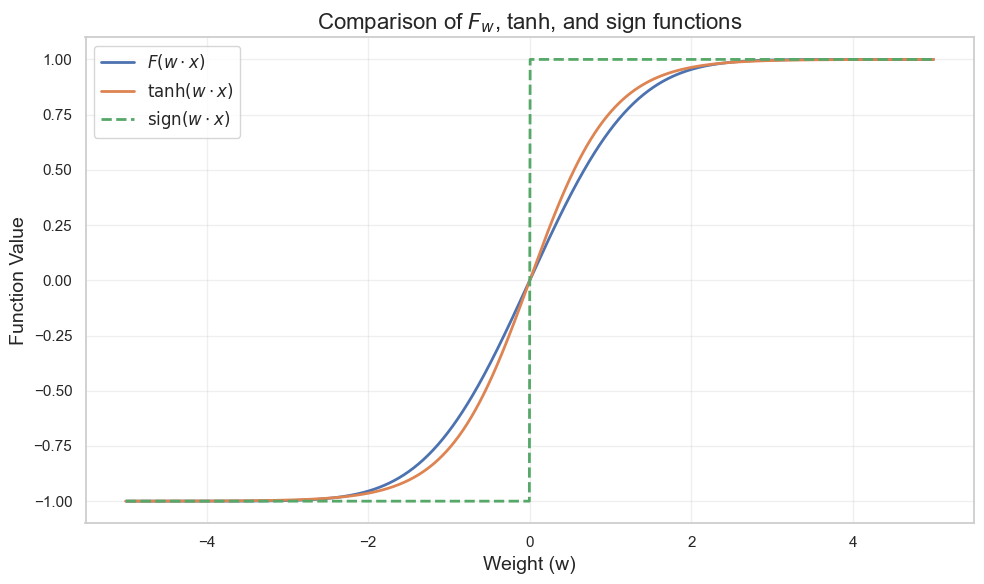

In [2]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

w = torch.linspace(-5, 5, 1000).view(-1, 1) 
x = torch.tensor([[1.0]])  
b = torch.tensor([0.0])  

# Compute F_ values
f_values = F_(x, w, b).view(-1).detach().numpy()

# Compute tanh(linear) for each w
linear = torch.matmul(x, w.T) + b  # Linear operation
tanh_values = torch.tanh(linear).view(-1).detach().numpy()

# Compute sign(linear) for each w
sign_values = torch.sign(linear).view(-1).detach().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=w.view(-1).numpy(), y=f_values, label=r"$F(w \cdot x)$", linewidth=2)
sns.lineplot(x=w.view(-1).numpy(), y=tanh_values, label=r"$\tanh(w \cdot x)$", linewidth=2)
sns.lineplot(x=w.view(-1).numpy(), y=sign_values, label=r"$\mathrm{sign}(w \cdot x)$", linewidth=2, linestyle="--")

plt.title("Comparison of $F_{w}$, tanh, and sign functions", fontsize=16)
plt.xlabel("Weight (w)", fontsize=14)
plt.ylabel("Function Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Insights:**

- By working with the aggregated function $F(w \cdot x)$, we obtain a fully differentiable function that is trainable using gradient-based methods. This stands in contrast to the non-differentiable nature of the sign function.

- The proximity of $F(w \cdot x)$ to $\tanh(w \cdot x)$ highlights its potential as a surrogate for $\tanh$ in PAC-Bayesian formulations. This is particularly beneficial in binary classification tasks where achieving a balance between smooth approximations and computational efficiency is essential.

### Gradients of $ F_w(x) $



$$
\frac{\partial F_w(x)}{\partial w} = \frac{2}{\sqrt{\pi}} \exp\left(-\left(\frac{w \cdot x}{\sqrt{2}\|x\|}\right)^2\right) \cdot \frac{x}{\sqrt{2}\|x\|}.
$$


These gradients are utilized during backpropagation to update the weights $w$ efficiently in the context of PAC-Bayesian neural networks.

### ErfFunction

Provided these informations we start by implementing an autodiff compatible function called `ErfFunction` which a variante of $ F_w(x) $ that includes a bias term.

As we will show later, this function will play the role of the input layer of a PAC-Bayesian-inspired neural network (PBGNet).

#### Key Features:
1. **Forward Pass**:
   - Implements a variante of $ F_w(x) $ that includes a bias term.
   - Computes and stores gradient-related quantities for the backward pass when in training mode.

2. **Backward Pass**:
   - Utilizes saved gradient values to propagate the gradients of the loss with respect to the input parameters (weights and biases).


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.nn.parameter import Parameter
import itertools
import math

class ErfFunction(Function):
    """Custom autograd function for input layer of PAC-Bayesian Binary Network."""

    @staticmethod
    def forward(ctx, input, weight, bias, sample_size, training):
        linear = F.linear(input, weight, bias)
        m = linear / (math.sqrt(2) * torch.norm(input, dim=1, keepdim=True))

        if training:
            # Computing and saving gradient
            exp_value = torch.exp(-(linear / (math.sqrt(2) * torch.norm(input, dim=1, keepdim=True))) ** 2)
            grad_b = exp_value * (math.sqrt(2) / (math.sqrt(math.pi) * torch.norm(input, dim=1, keepdim=True)))
            grad_w = exp_value.unsqueeze(1) * ((input.unsqueeze(-1) * math.sqrt(2)) / (math.sqrt(math.pi) * torch.norm(input, dim=1, keepdim=True)).unsqueeze(-1))
            ctx.save_for_backward(grad_w, grad_b)

        return torch.erf(m)

    @staticmethod
    def backward(ctx, grad_output):
        grad_w, grad_b = ctx.saved_tensors

        # Backpropagation
        grad_w = ((grad_output.unsqueeze(1) * grad_w).sum(0)).t()
        grad_b = (grad_output * grad_b).sum(0)

        return None, grad_w, grad_b, None, None

## BAM one hidden layer network

To emphisize the importance of the function $F_{w}$, we start by presenting the case of a one-hidden layer network.

$$
f_\theta(x) = \text{sgn}(w_2 \ . \ \text{sgn}(W_1 x))).
$$

For such network, and under Gaussian posterior assumption, we are able to derive the corresponding aggregated function $F_{\theta}$ given by :

1. **Output Function $F_\theta(x)$:**

$$
F_\theta(x) 
    = \sum_{s \in \{-1, 1\}^{d_1}} \text{erf}\left(\frac{w_2 \cdot s}{\sqrt{2} d_1}\right) \Psi_s(x, \mathbf{W}_1),
$$

2. **Aggregation Term $\Psi_s(x, \mathbf{W}_1)$:**

$$
\Psi_s(x, \mathbf{W}_1) 

    = \prod_{i=1}^{d_1} \left[\frac{1}{2} + \frac{s_i}{2} \text{erf}\left(\frac{w_1^i \cdot x}{\sqrt{2} \|x\|}\right)\right].
$$

where $w_1^i$ is the i-th row of $W_1$.

### Insights :

1. **$\Psi_s(x, \mathbf{W}_1)$**:
   - We recognize *ErfFunction* defined earlier in the term $\text{erf}\left(\frac{w_1^i \cdot x}{\sqrt{2} \|x\|}\right)$.
   - This term can be interpreted as the probability of mapping the input $x$ into the hidden representation $s$, given the parameters $\mathbf{W}_1$.
   - Formally, this can be expressed as:
     $$
     \Pr(s | x, \mathbf{W}_1) = \Psi_s(x, \mathbf{W}_1).
     $$
   - The distribution $\Psi_s$ plays a critical role in aggregating the outputs of all possible binary hidden states $s \in \{-1, 1\}^{d_1}$, weighted by their probabilities. This aggregation allows for computing the final network output $F_\theta(x)$ as a sum over all possible configurations of $s$.


2. **$F_\theta(x)$**:
   - This function represents the output neuron of the model as an aggregation over the hidden layer's activation values.
   - The aggregation is performed over all possible binary activation patterns $s \in \{-1, 1\}^{d_1}$, **which is not tractable in practice**.
   - The network output $F_\theta(x)$ can be seen as a **"majority vote"** over the binary representations $s$. Each $s$ contributes to the output, weighted by its associated probability $\Psi_s(x, \mathbf{W}_1)$. This ensures that the final output reflects the most probable configurations of hidden representations.
  
## Numerical Approximation :

#### MC approximation for single hidden layer output $F_\theta(x)$ :

- Following the interpretation of $\Psi_s(x, \mathbf{W}_1)$ as a distribution, we can write:  
  $$ 
  F_{\theta}(x) = \mathbb{E}_{s \sim \Pr(s \mid x, \mathbf{W}_1)}\Bigl[\mathrm{erf}\!\Bigl(\frac{\mathbf{w}_2 \cdot s}{\sqrt{2 d_1}}\Bigr)\Bigr]. 
  $$

- This allows to approximate this function using an MC estimator to avoid numerical intractability linked to computation of the value of $F_{\theta}(x)$.

- To approximate $F_{\theta}(x)$, we generate $T$ random binary vectors $Z := \{s^t\}_{t=1}^T$ according to the distribution $\Psi_s(x, \mathbf{W}_1)$. This can be achieved by uniformly sampling $z^t_i \in \{0, 1\}$, and setting $s^t_i = \text{sgn}(\phi(x \mathbf{w}_i^1) - z^t_i)$. The approximation is denoted as $\hat{F}_{\theta}(x)$, given by:  
$$
\hat{F}_{\theta}(x) := \frac{1}{T} \sum_{t=1}^T \mathrm{erf}\!\Bigl(\frac{\mathbf{w}_2 \cdot s^t}{\sqrt{2 d_1}}\Bigr).
$$

#### MC approximation of the gradient :
- Since we considere a MC approximation of $F_\theta(x)$ we need to adapte this approche for the computation of the gradient also.

#### 1. Gradient w.r.t. $\mathbf{w}_2$

The gradient w.r.t. $\mathbf{w}_2$ is straightforward because $\mathbf{w}_2$ is directly used in the argument of the erf function:

$$
\frac{\partial F_{\theta}(x)}{\partial \mathbf{w}_2} = \mathbb{E}_{s \sim \Phi(s \mid x, \mathbf{W}_1)} \Bigg[ \frac{\partial}{\partial \mathbf{w}_2} \mathrm{erf}\Bigl(\frac{\mathbf{w}_2 \cdot s}{\sqrt{2d_1}}\Bigr) \Bigg].
$$


In practice, this expectation is approximated via Monte Carlo sampling. For $T$ samples $s^{(t)}$ from $\Phi(s \mid x, \mathbf{W}_1)$, we have:

$$
\frac{\partial F_{\theta}(x)}{\partial \mathbf{w}_2} \approx \frac{1}{T} \sum_{t=1}^T \frac{\partial}{\partial \mathbf{w}_2} \mathrm{erf}\Bigl(\frac{\mathbf{w}_2 \cdot s^{(t)}}{\sqrt{2d_1}}\Bigr)
.
$$


#### 2. Gradient w.r.t. $\mathbf{W}_1$

The gradient w.r.t. $\mathbf{W}_1$ is more complex because $\mathbf{W}_1$ appears in the distribution $\Phi(s \mid x, \mathbf{W}_1)$, which governs the sampling of $s$. Using the **REINFORCE** rule, the gradient of the expectation can be written as:

$$
\frac{\partial F_{\theta}(x)}{\partial \mathbf{W}_1} = \mathbb{E}_{s \sim \Phi(s \mid x, \mathbf{W}_1)} \Bigg[ \mathrm{erf}\Bigl(\frac{\mathbf{w}_2 \cdot s}{\sqrt{2d_1}}\Bigr) \frac{\partial}{\partial \mathbf{W}_1} \log \Phi(s \mid x, \mathbf{W}_1) \Bigg].
$$


As with $\mathbf{w}_2$, this expectation can be approximated using Monte Carlo sampling:

$$
\frac{\partial F_{\theta}(x)}{\partial \mathbf{W}_1} \approx \frac{1}{T} \sum_{t=1}^T \mathrm{erf}\Bigl(\frac{\mathbf{w}_2 \cdot s^{(t)}}{\sqrt{2d_1}}\Bigr) \frac{\partial}{\partial \mathbf{W}_1} \log \Phi(s^{(t)} \mid x, \mathbf{W}_1).
$$

The previous insights and explanations motivate the implementation of the following transformation


In [4]:
class StochasticBinaryFunction(Function):
    """Custom autograd function for hidden/output layers of PAC-Bayesian Binary Network"""
    
    @staticmethod
    def forward(ctx, input, weight, bias, sample_size, training, is_output=False):
        # Probability for binary activation
        proba = 0.5 + 0.5 * input
        s = proba.unsqueeze(-1).expand(*proba.shape, sample_size)
        s = 2 * torch.bernoulli(s) - 1  # Binary stochastic sampling
        
        # Linear transformation
        linear = F.linear(s.transpose(1, 2), weight, bias)
        normalization_factor = math.sqrt(2 * input.shape[1])
        erf_value = torch.erf(linear / normalization_factor)
        
        if is_output:  # Specific adjustment for the output layer
            erf_value = erf_value.squeeze(-1)
        
        norm_term = 1 / sample_size
        
        if training:
            # Compute gradients
            exp_value = torch.exp(-(linear / normalization_factor) ** 2)
            
            if is_output:  # Adjust dimensions for output layer
                exp_value = exp_value.squeeze()
            
            grad_b = exp_value * (math.sqrt(2) / (math.sqrt(math.pi * input.shape[1])))
            grad_w = ((s * math.sqrt(2)) / (math.sqrt(math.pi * input.shape[1]))).matmul(exp_value.unsqueeze(-1))
            
            if is_output:
                grad_w = grad_w.squeeze()
            
            grad_w = norm_term * grad_w
            grad_b = norm_term * grad_b.sum(-1 if is_output else 1)
            
            p_s = 0.5 + 0.5 * input.unsqueeze(-1) * s
            grad_input = (s / (2 * p_s)).matmul(erf_value.unsqueeze(-1) if is_output else erf_value)
            grad_input = norm_term * grad_input.squeeze() if is_output else grad_input
            
            ctx.save_for_backward(grad_input, grad_w, grad_b)
        
        output = norm_term * erf_value.sum(-1 if is_output else 1)
        return output.unsqueeze(-1) if is_output else output

    @staticmethod
    def backward(ctx, grad_output):
        grad_input, grad_w, grad_b = ctx.saved_tensors
        
        # Backpropagation
        grad_w = ((grad_output.unsqueeze(1) * grad_w).sum(0)).t() if grad_w.ndim == 3 else (grad_output * grad_w).sum(0).unsqueeze(0)
        grad_b = (grad_output * grad_b).sum(0)
        grad_input = (grad_output.unsqueeze(1) * grad_input).sum(-1) if grad_input.ndim == 3 else grad_output * grad_input
        
        return grad_input, grad_w, grad_b, None, None, None

## Elements of PAC-Bayes Theory

The PAC-Bayesian framework provides a bound on the generalization error of a learned model, balancing empirical performance and model complexity. Using **Catoni's Bound**, the PAC-Bayesian inequality introduces a tunable parameter $C > 0$ to trade off between these components:

$$
L_D(F_Q) \leq \frac{1}{1 - e^{-C}} \left(1 - \exp\left(-C \cdot L_S(F_Q) - \frac{\text{KL}(Q \| P) + \ln \frac{1}{\delta}}{n}\right)\right).
$$

Here:
- $L_D(F_Q)$: Generalization loss on the data distribution $D$.
- $L_S(F_Q)$: Empirical loss (training error) on the sample $S$.
- $\text{KL}(Q \| P)$: Kullback-Leibler (KL) divergence between the posterior $Q$ (learned parameters) and the prior $P$ (reference parameters).
- $\delta$: Confidence parameter, with $1 - \delta$ being the confidence level.
- $n$: Number of training examples.
- $C$: Trade-off parameter that controls the balance between empirical loss and model complexity.


### Advantages:
- **Theoretical Guarantees**: The architecture provides a mathematically rigorous guarantee on the model's generalization performance.
- **Generalization Guarantee**: This formulation inherently controls overfitting by penalizing complex models that deviate significantly from the prior.
- **Integrated Model Selection**: The bound not only guides training but also acts as a criterion for hyperparameter and model selection, ensuring optimal trade-offs.

### Approach testing:
In testing, we consider comparing the PAC-Bayesian bound obtained by minimizing this bound directly with the results of minimizing the linear loss with $L_2$ regularization (**pbgnet** vs **pbgnet_ll**). We track the model's accuracy as a control metric during the training process, and we access the bound value in both cases as well as the overfitting mitigation of each regularization.

Below we implement the both the linear loss $\ell(y,y')$, the accuracy function and this bound.

In [5]:
def linear_loss(pred_y, y):
    """Linear loss function."""
    return torch.mean((1 -(y * pred_y)) / 2)

def accuracy(pred_y, y):
    """Binary classification accuracy function."""
    pred_y_copy = pred_y.clone()
    pred_y_copy[pred_y_copy < 0] = -1
    pred_y_copy[pred_y_copy >= 0] = 1
    acc_pred = (pred_y_copy == y).float().sum() / y.shape[0]
    return acc_pred * 100


def bound(linear_loss, kl, delta, n_examples, C):
    """Bound computation as presented in Theorem 3. for given C values."""
    bound_value = (1 / (1 - torch.exp(-C))) * \
                  (1 - torch.exp(-C * linear_loss - (1 / n_examples) * \
                  (kl + math.log(2 * math.sqrt(n_examples) / delta))))

    return bound_value


## General BAM Architecture

The **Binary-Activated Multilayer (BAM)** architecture extends traditional deep networks by leveraging **binary activations** while maintaining differentiability using stochastic approximations. Instead of relying on continuous activations such as ReLU or tanh, BAM networks operate with discrete sign activations, enhancing computational efficiency.

A straightforward approach to extending BAM networks to deeper architectures would be to consider a **Gaussian posterior distribution** $ Q(\theta) = \mathcal{N}(\theta, I_D) $ over the family of BAM networks $ f_\theta $. However, this results in a **deterministic network** requiring computation over an exponential number of terms:

$$
\sum_{k=1}^{L} 2^{d_k}
$$

which becomes infeasible for large architectures. To address this, we introduce a novel **computation tree mapping** for BAM networks, transforming the BAM structure into an efficiently computable form.


### **BAM to Tree Architecture Mapping**
Given a BAM network $ f_\theta $ with $ L $ layers of sizes $ d_0, d_1, \dots, d_L $ (where $ d_L = 1 $ for binary classification), we **decouple neurons** into a computation tree. This mapping ensures:

1. **Decoupling of network layers**: Each computation node in the tree corresponds to a neuron in the BAM network.
2. **Efficient recursive computation**: Instead of summing over exponentially many terms, we introduce a recursive formulation.
3. **Parameter sharing across the tree**: Each weight vector is efficiently mapped, avoiding unnecessary redundancy.

Each input-to-output path in the original BAM network becomes a **path of length $ L $ in the computation tree**. The **total number of edges** in the tree is:

$$
D^\dagger := \sum_{k=0}^{L-1} d^\dagger_k, \quad \text{with} \quad d^\dagger_k := \prod_{i=k}^{L} d_i.
$$

where $ d^\dagger_k $ represents the number of nodes at layer $ k $.

<div style="text-align: center;">
    <img src="model architecture.png" alt="Centered Image">
</div>

### **BAM to Tree Parameter Mapping**
The BAM weight parameters $ \theta $ are **transformed** into an equivalent computation tree representation using a recursive mapping function:

$$
\zeta(\theta) = \{ w_L, \zeta_1(\theta_{1:L-1}), \dots, \zeta_{d_L-1}(\theta_{1:L-1}) \}
$$

where the transformation follows:

$$
\zeta_i(\theta_{1:k}) = \{ w^i_k, \zeta_1(\theta_{1:k-1}), \dots, \zeta_{d_k-1}(\theta_{1:k-1}) \}.
$$

This results in a **highly redundant structure** where each weight vector $ w_k^i $ is replicated $ d^\dagger_{k+1} $ times.

Thus, we ensure that:

$$
f_{\theta}(x) = g_{\zeta(\theta)}(x), \quad \forall x \in \mathbb{R}^{d_0}.
$$


### **Recursive Computation Tree Formulation**
The **output of the computation tree** is defined recursively. Given an input $ x $, we define the expected predictor $ G_{\theta}(x) $ as:

$$
G_{\theta}(x) = \mathbb{E}_{\eta \sim Q_{\zeta(\theta)}} g_{\eta}(x),
$$

where $ Q_{\zeta(\theta)} $ is a Gaussian prior over the parameter tree, and $ g_{\eta}(x) $ is the corresponding BAM-to-tree mapped function.

G(j) 1:k+1 (x)thefunctionreturningthejthneuronvalueofthelayerk+1, we define:


The computation follows:

1. **Base Case (`ErfFunction`)**: The first-layer neuron activations are given by:

   $$
   G^{(j)}_{1:1}(x) = \int_{\mathbb{R}^{d_0}} Q(w^{(j)}_1) \, \text{sgn}(w^{(j)}_1 \cdot x) \, dv = \text{erf} \left( \frac{w^{(j)}_1 \cdot x}{\sqrt{2 x}} \right).
   $$

2. **Recursive Case (`StochasticBinaryFunction`)**: For each neuron in the hidden layers,

$$
G_{\theta_{1:k+1}}^{(j)} (\mathbf{x}) = \frac{1}{T} \sum_{t=1}^T
\text{erf} \left( \frac{ w_{k+1}^{j} \cdot \mathbf{s^{(t)}} }{\sqrt{2 d_k}} \right) 
$$

where $s^{(t)}$ is sampled following :

$$
\Psi_{\mathbf{s}}^{k} (\mathbf{x}, \theta) = \prod_{i=1}^{d_k} 
\left( \frac{1}{2} + \frac{1}{2} s_i \times G_{\theta_{1:k}}^{(i)} (\mathbf{x}) \right).
$$


3. **Final Output (Root of the Tree)**: The final network output is obtained at the root neuron,

   $$
   G_{\theta}(x) = G^{(1)}_{1:L}(x).
   $$

This **recursive formulation** allows sequential computation of hidden layer activations, significantly reducing the computational complexity from an **exponential sum of terms** to a **tractable layer-wise summation**.


In [6]:
# implementation of the generale BAM network

class PBGLayer(torch.nn.Module):
    """PAC-Bayesian Binary Gradient Network architecture layer module.

    Args:
        in_features (int): Size of each input sample.
        out_features (int): Size of each output sample.
        position (str): Position of layer in PBGNet architecture (either 'input', 'hidden' or 'output')
        sample_size (int): Sample size T for Monte Carlo approximation (Default value = 100).
    """

    def __init__(self, in_features, out_features, position, sample_size=100):
        super(PBGLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.position = position
        self.sample_size = sample_size

        self.weight = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(out_features))

        self.priors = torch.nn.ParameterDict({'weight': Parameter(torch.Tensor([0.0]), requires_grad=False),
                                              'bias': Parameter(torch.Tensor([0.0]), requires_grad=False)})

        if self.position == 'input':
            self.forward_fct = ErfFunction
        else:
            self.forward_fct = StochasticBinaryFunction


    def forward(self, input):
        is_output = self.position == 'output'
        return self.forward_fct.apply(input, self.weight, self.bias, self.sample_size, self.training, is_output)

    def __repr__(self):
        return f"{self.__class__.__name__}_{self.position} (in_features={self.in_features}, out_features={self.out_features})"


class PBGNet(torch.nn.Module):
    """PAC-Bayesian Binary Gradient Network architecture (stochastic approximation) PyTorch module.

    Args:
        input_size (int): Input data point dimension d_0.
        hidden_layers (list): List of number of neurons per layers from first layer d_1 to before last layer d_{L-1}.
        n_examples (int): Number of examples in the training set, used for bound computation.
        sample_size (int): Sample size T for Monte Carlo approximation (Default value = 100).
        delta (float): Delta parameter of PAC-Bayesian bounds, see Theorem 1 (Default value = 0.05).
    """

    def __init__(self, input_size, hidden_layers, n_examples, sample_size=64, delta=0.05):
        super(PBGNet, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.n_examples = n_examples
        self.sample_size = sample_size
        self.delta = delta
        self.t = Parameter(torch.Tensor(1))
        self.metrics = {}

        self.layers = torch.nn.ModuleList()
        self.layers.append(PBGLayer(self.input_size, self.hidden_layers[0], 'input', sample_size))
        for in_dim, out_dim in zip(self.hidden_layers[:-1], self.hidden_layers[1:]):
            self.layers.append(PBGLayer(in_dim, out_dim, 'hidden', sample_size))
        self.layers.append(PBGLayer(self.hidden_layers[-1], 1, 'output', sample_size))

    def forward(self, input):
        for layer in self.layers:
            input = layer(input)
        return input

    def bound(self, pred_y, y):
        """Bound computation as presented in Theorem 3. with the learned C value."""
        loss = linear_loss(pred_y, y)

        C = torch.exp(self.t)
        kl = self.compute_kl()
        bound_value = bound(loss, kl, self.delta, self.n_examples, C)
        return bound_value

    def compute_kl(self):
        """Kullback-Leibler divergence computation as presented in equation 17."""
        kl = 0
        coefficient = 1
        for i, layer in zip(itertools.count(len(self.layers) -1, -1), reversed(self.layers)):
            norm = torch.norm(layer.weight - layer.priors['weight']) ** 2 + \
                                 torch.norm(layer.bias - layer.priors['bias']) ** 2
            kl += coefficient * norm
            coefficient *= layer.out_features
        return 0.5 * kl

    def set_priors(self, state_dict):
        """Sets network parameters priors."""
        for i, layer in enumerate(self.layers):
            layer.priors['weight'] = Parameter(state_dict[f"layers.{i}.weight"].data.clone(), requires_grad=False)
            layer.priors['bias'] = Parameter(state_dict[f"layers.{i}.bias"].data.clone(), requires_grad=False)

    def init_weights(self):
        """Network parameters random initialization."""
        self.t.data.zero_()
        for layer in self.layers:
            if isinstance(layer, PBGLayer):
                torch.nn.init.xavier_normal_(layer.weight)
                layer.bias.data.zero_()

    def set_sample_size(self, sample_size):
        """Allows to modify the sample size at any given time."""
        self.sample_size = sample_size
        for layer in self.layers:
            layer.sample_size = sample_size

## **Baseline Model**

As was motivated earlier in the **comparison plots between $\operatorname{erf}$ and $\tanh$**, we had the insight:

> *The proximity of $F(w \cdot x)$ to $\tanh(w \cdot x)$ highlights its potential as a surrogate for $\tanh$ in PAC-Bayesian formulations. This is particularly beneficial in binary classification tasks where achieving a balance between smooth approximations and computational efficiency is essential.*

To further investigate this relationship and assess model performance, we consider a **baseline model** with **tanh activation** for comparison.


In [7]:
class BaselineNet(torch.nn.Module):
    """Standard neural network architecture used as a baseline.

    Args:
        input_size (int): Input data point dimension d_0.
        hidden_layers (list): List of number of neurons per layers from first layer d_1 to before last layer d_{L-1}.
        activation_fct (function): Activation function.
    """

    def __init__(self, input_size, hidden_layers, activation_fct):
        super(BaselineNet, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.activation_fct = activation_fct

        self.layers = []
        for in_dim, out_dim in zip([self.input_size, *self.hidden_layers], [*self.hidden_layers, 1]):
            self.layers.append(nn.Linear(in_dim, out_dim))
            self.layers.append(self.activation_fct())
        self.layers = nn.Sequential(*self.layers)

    def forward(self, input):
        return self.layers(input)

    def init_weights(self):
        """Network parameters random initialization."""
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight)
                layer.bias.data.zero_()

## **Model Training**

### **Considered Models**
1. **P**AC-Bayesian **B**inary **G**radient Network (**PBGNet**)  
   - Trained by minimizing the **PAC-Bayesian bound** instead of the empirical loss.
   - Uses either a **Gaussian prior** or a **pretrained prior**.
   
2. **PBGNet with a pretrained prior** (**PBGNet-Pretrain**)  
   - Instead of using a Gaussian prior, the prior is obtained through **pretraining on a subset of the dataset**.
   - The PAC-Bayesian bound is minimized during the final training phase.

3. **PBGNet with a linear loss objective** (**PBGNet-ll**)  
   - Optimized using **linear loss with $L_2$ regularization** instead of the PAC-Bayesian bound.
   - Incorporates PAC-Bayesian components (such as KL divergence tracking) but does not use the bound for training.

4. **Baseline Model**  
   - A standard **fully connected network with tanh activations**.
   - Trained using empirical risk minimization (ERM) with **cross-entropy loss**.

### **Optimization Objectives**
The training objectives depend on the selected model:

- **PAC-Bayesian Bound Optimization** (for **PBGNet** and **PBGNet-Pretrain**):  
  - The **bound function** is explicitly used as the loss function.
  - The model is trained to **minimize the bound**, which includes the empirical loss and the KL divergence between the prior and posterior distributions.
  - **Best model selection is based on the PAC-Bayesian bound.**
  
- **Linear Loss Optimization with $L_2$ Regularization** (for **PBGNet-ll** and **Baseline**):  
  - The objective is to minimize a **linear loss function** with **weight decay (L2 penalty)**.
  - The best model is selected based on **validation loss** instead of the PAC-Bayes bound.

### **Training Procedure**
The training follows two key phases:

#### **1. Pretraining Phase (Only for PBGNet-Pretrain)**
- Instead of initializing with a **Gaussian prior**, the prior is learned by training a **separate network** on a **subset of the dataset**.
- This is achieved by running a **pretraining loop for 5 epochs**, where:
  - The **PBGNet architecture** is trained using **linear loss**.
  - The best pretraining checkpoint is selected based on **training loss**.
  - The trained parameters are then used as the **prior** for the final PAC-Bayes training phase.

#### **2. Main Training Phase**
- **For PBGNet and PBGNet-Pretrain**:  
  - The **PAC-Bayesian bound** is used as the loss function.
  - If using an **informative prior** (Pretrain or Init), the **training and validation sets are merged**.
  - The best model is selected based on the **bound** value.

- **For PBGNet-ll and Baseline**:  
  - The **linear loss function** is used with **weight decay** for regularization.
  - The **validation set is retained**, and the best model is selected based on **validation loss**.

- **For all models**:
  - The optimizer is **Adam**.
  - Learning rate is reduced dynamically using **ReduceLROnPlateau** (patience = 20).
  - **Early stopping** is applied when validation performance does not improve.

### **Model Selection and Testing**
At the end of training:
1. The best model checkpoint is **restored based on the primary objective** (PAC-Bayes bound for PBGNet, validation loss for others).
2. **For baseline models**, additional **binary network testing** is performed by replacing the **tanh activations with sign activations**.
3. **PAC-Bayesian models use an MC estimator**, meaning their test performance and bound estimation **depend on sampling**, so multiple runs are necessary to **compute a stable estimate**. For these models, additional **Monte Carlo (MC) repetitions (default: 20 runs)** are conducted to estimate test performance and bound statistics.



## **Logging function**

Before defining the training function, we begin by defining a logger function to handle and record logs efficiently

In [8]:
from poutyne.framework.metrics.epoch_metrics import EpochMetric

def get_logging_dir_name(experiment_setting):
    """Map experiment config dictionnary to a unique directory name."""
    return f"{experiment_setting['network']}_H{experiment_setting['hidden_layers']}-{experiment_setting['hidden_size']}"\
            + f"_B{experiment_setting['batch_size']}_{experiment_setting['optim_algo']}_WD{experiment_setting['weight_decay']}"\
            + f"_LR{experiment_setting['learning_rate']}_P{experiment_setting['lr_patience']}"\
            + f"_V{experiment_setting['valid_size']}_R{experiment_setting['random_seed']}"\
            + (f"_S{experiment_setting['sample_size']}_{experiment_setting['prior']}" if experiment_setting['network'].startswith('pbg') else "")\
            + (f"_PE{experiment_setting['pre_epochs']}" if experiment_setting['prior'] == 'pretrain' else "")

class MasterMetricLogger(EpochMetric):
    """Computes all bound related epoch metrics (linear loss, kl, C, bound)."""

    def __init__(self, network, loss_function, delta, n_examples, C_range=None):
        super().__init__()
        self.network = network
        self.loss_function = loss_function
        self.delta = delta
        self.n_examples = n_examples
        self.C_range = C_range
        self.__name__ = self.loss_function.__name__
        self.reset()

    def forward(self, y_prediction, y_true):
        self.loss_sum += self.loss_function(y_prediction, y_true) * y_true.shape[0]
        self.example_sum += y_true.shape[0]

    def reset(self):
        self.loss_sum = 0
        self.example_sum = 0

    def get_metric(self):
        loss = self.loss_sum / self.example_sum
        with torch.no_grad():
            C = torch.exp(self.network.t) if self.C_range is None else self.C_range
            kl = self.network.compute_kl()

            bound_value = bound(loss, kl, self.delta, self.n_examples, C)
        metrics = {'linear_loss': loss.item(), 'kl': kl.item()}
        if self.C_range is None:
            metrics.update({'C': C.item(), 'bound': bound_value.item()})
        else:
            min_idx = bound_value.argmin()
            metrics.update({'C': C[min_idx].item(), 'bound': bound_value[min_idx].item()})
        self.network.metrics.update(metrics)
        return loss

class MetricLogger(EpochMetric):
    """Logs a single epoch metric (key) computed by the MasterMetricLogger."""

    def __init__(self, network, key):
        super().__init__()
        self.network = network
        self.key = key
        self.__name__ = key

    def forward(self, y_prediction, y_true):
        pass
        
    def reset(self):
        pass

    def get_metric(self):
        return self.network.metrics[self.key]

## **Training function**

Below is the training function aligned with the model training described above.

In [9]:
import json

import os
from os.path import join, abspath, dirname, exists
from os import makedirs
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

from poutyne.framework import Model, Experiment
from poutyne.framework.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from poutyne.layers import Lambda


def train(dataset="adult", 
           experiment_name="test", 
           network="pbgnet", 
           hidden_size=64, 
           hidden_layers=3, 
           sample_size=500, 
           weight_decay=0, 
           prior="init", 
           learning_rate=0.001, 
           lr_patience=20, 
           optim_algo="adam", 
           epochs=50, 
           batch_size=32, 
           valid_size=0.2, 
           pre_epochs=5, 
           stop_early=0, 
           gpu_device=0, 
           random_seed=42, 
           logging=True):

    # Setting random seed for reproducibility
    random_state = check_random_state(random_seed)
    torch.manual_seed(random_seed)

    # Pac-Bayes Bound parameters
    delta = 0.05
    C_range = torch.Tensor(np.arange(0.1, 20.0, 0.01))

    # Setting GPU device
    device = None
    if torch.cuda.is_available() and gpu_device != -1:
        torch.cuda.set_device(gpu_device)
        device = torch.device('cuda:%d' % gpu_device)
        print("Running on GPU %d" % gpu_device)
    else:
        print("Running on CPU")

    # Logging
    experiment_setting = dict([('experiment_name', experiment_name), ('dataset', dataset), ('network', network),
                               ('hidden_size', hidden_size), ('hidden_layers', hidden_layers),
                               ('sample_size', sample_size), ('epochs', epochs), ('weight_decay', weight_decay),
                               ('prior', prior), ('learning_rate', learning_rate), ('lr_patience', lr_patience),
                               ('optim_algo', optim_algo), ('batch_size', batch_size), ('valid_size', valid_size),
                               ('pre_epochs', pre_epochs), ('stop_early', stop_early), ('random_seed', random_seed)])

    directory_name = get_logging_dir_name(experiment_setting)

    logging_path = join(RESULTS_PATH, experiment_name, dataset, directory_name)
    if logging:
        if not exists(logging_path): makedirs(logging_path)
        with open(join(logging_path, "setting.json"), 'w') as out_file:
            json.dump(experiment_setting, out_file, sort_keys=True, indent=4)

    # Loading dataset
    dataset_loader = DatasetLoader(random_state=random_state)
    X_train, X_test, y_train, y_test = dataset_loader.load(dataset)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                          y_train,
                                                          test_size=valid_size,
                                                          random_state=random_state)

    # Experiment
    batch_metrics = [accuracy]
    epoch_metrics = []
    save_every_epoch = False
    cost_function = linear_loss
    monitor_metric = 'val_loss'
    valid_set_use = 'val'
    callbacks = []

    if network == 'pbgnet':
        print("### Using Pac-Bayes Binary Gradient Network ###")
        if prior in ['zero', 'init']:
            valid_set_use = 'train'
            X_train = np.vstack([X_train, X_valid])
            y_train = np.vstack([y_train, y_valid])
        elif prior == 'pretrain':
            valid_set_use = 'pretrain'

        if network == 'pbgnet':
            net = PBGNet(X_train.shape[1], hidden_layers * [hidden_size], X_train.shape[0], sample_size, delta)
        else:
            raise ValueError("Unknown network architecture")
        monitor_metric = 'bound'
        cost_function = net.bound
        epoch_metrics.append(MasterMetricLogger(network=net,
                                                loss_function=linear_loss,
                                                delta=delta,
                                                n_examples=X_train.shape[0]))

    elif network == 'pbgnet_ll':
        print("### Using PAC-Bayes Gradient Network Architecture and Optimizing Linear Loss ###")
        if network == 'pbgnet_ll':
            net = PBGNet(X_train.shape[1], hidden_layers * [hidden_size], X_train.shape[0], sample_size, delta)
        else:
            raise ValueError("Unknown network architecture")
        epoch_metrics.append(MasterMetricLogger(network=net,
                                                loss_function=linear_loss,
                                                delta=delta,
                                                n_examples=X_train.shape[0],
                                                C_range=C_range.to(device)))
        callbacks.append(ModelCheckpoint(join(logging_path, 'bound_checkpoint_epoch.ckpt'),
                                         temporary_filename=join(logging_path, 'bound_checkpoint_epoch.tmp.ckpt'),
                                         monitor='bound',
                                         mode='min',
                                         save_best_only=True))
    elif network == "baseline":
        print("### Running the Baseline Network with Tanh activations ###")
        net = BaselineNet(X_train.shape[1], hidden_layers * [hidden_size], torch.nn.Tanh)

    if network.startswith('pb'):
        epoch_metrics.append(MetricLogger(network=net, key='bound'))
        epoch_metrics.append(MetricLogger(network=net, key='kl'))
        epoch_metrics.append(MetricLogger(network=net, key='C'))

    # Parameters initialization
    if prior in ['zero', 'init']:
        net.init_weights()

    elif prior == 'pretrain':
        print("### Pre-training network ###")
        if network == 'pbgnet':
            pre_net = PBGNet(X_valid.shape[1], hidden_layers * [hidden_size], X_valid.shape[0], sample_size, delta)
        else:
            raise ValueError("Unknown network architecture")

        pre_net.init_weights()
        pre_optimizer = torch.optim.Adam(pre_net.parameters(), lr=learning_rate, weight_decay=0.0)
        pre_logging_path = join(logging_path, 'pretrain')
        if not exists(pre_logging_path): makedirs(pre_logging_path)

        pretrain = Experiment(directory=pre_logging_path,
                              network=pre_net,
                              optimizer=pre_optimizer,
                              loss_function=linear_loss,
                              monitor_metric='loss',
                              device=device,
                              logging=logging,
                              batch_metrics=[accuracy])

        pretrain_loader = DataLoader(TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid)),
                                     batch_size,
                                     shuffle=True)

        pretrain.train(train_generator=pretrain_loader,
                       valid_generator=None,
                       epochs=pre_epochs,
                       save_every_epoch=False,
                       disable_tensorboard=True,
                       seed=random_seed)

        history = pd.read_csv(pretrain.log_filename, sep='\t')
        best_epoch_index = history['loss'].idxmin()
        best_epoch_stats = history.iloc[best_epoch_index:best_epoch_index + 1]
        best_epoch = best_epoch_stats['epoch'].item()
        ckpt_filename = pretrain.best_checkpoint_filename.format(epoch=best_epoch)
        weights = torch.load(ckpt_filename, map_location='cpu')

        net.load_state_dict(weights, strict=False)

    print("### Training ###")

    # Setting prior
    if network.startswith('pb') and prior in ['init', 'pretrain']:
        net.set_priors(net.state_dict())

    # Adding early stopping and lr scheduler
    reduce_lr = ReduceLROnPlateau(monitor=monitor_metric, mode='min', patience=lr_patience, factor=0.5, \
                                  threshold_mode='abs', threshold=1e-4, verbose=True)
    lr_schedulers = [reduce_lr]

    early_stopping = EarlyStopping(monitor=monitor_metric,
                                   mode='min',
                                   min_delta=1e-4,
                                   patience=stop_early,
                                   verbose=True)
    if stop_early > 0:
        callbacks.append(early_stopping)

    # Initializing optimizer
    if optim_algo == "sgd":
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optim_algo == "adam":
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Creating Poutyne experiment
    expt = Experiment(directory=logging_path,
                      network=net,
                      optimizer=optimizer,
                      loss_function=cost_function,
                      monitor_metric=monitor_metric,
                      device=device,
                      logging=logging,
                      batch_metrics=batch_metrics,
                      epoch_metrics=epoch_metrics)

    # Initializing data loaders
    train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size, shuffle=True)
    valid_loader = None
    if valid_set_use == 'val':
        valid_loader = DataLoader(TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid)), batch_size)

    # Launching training
    expt.train(train_generator=train_loader,
               valid_generator=valid_loader,
               epochs=epochs,
               callbacks=callbacks,
               lr_schedulers=lr_schedulers,
               save_every_epoch=save_every_epoch,
               disable_tensorboard=True,
               seed=random_seed)

    print("### Testing ###")
    sign_act_fct = lambda: Lambda(lambda x: torch.sign(x))
    test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size)

    if network == 'baseline':
        expt.test(test_generator=test_loader, checkpoint='best', seed=random_seed)
        # Binary network testing (sign activation)
        best_epoch = expt.get_best_epoch_stats()['epoch'].item()
        ckpt_filename = expt.best_checkpoint_filename.format(epoch=best_epoch)
        binary_net = BaselineNet(X_test.shape[1], hidden_layers * [hidden_size], sign_act_fct)
        weights = torch.load(ckpt_filename, map_location='cpu')
        binary_net.load_state_dict(weights, strict=False)
        binary_model = Model(binary_net, 'sgd', linear_loss, batch_metrics=[accuracy])
        test_loss, test_accuracy = binary_model.evaluate_generator(test_loader, steps=None)
        test_stats = pd.read_csv(expt.test_log_filename.format(name='test'), sep='\t')
        test_stats['bin_test_linear_loss'] = test_loss
        test_stats['bin_test_accuracy'] = test_accuracy
        test_stats['linear_loss'] = test_stats['loss']
        test_stats['val_linear_loss'] = test_stats['val_loss']
        test_stats['test_linear_loss'] = test_stats['test_loss']
        test_stats.to_csv(expt.test_log_filename.format(name='test'), sep='\t', index=False)

    def pbgnet_testing(target_metric, irrelevant_columns, n_repetitions=20):
        print(f"Restoring best model according to {target_metric}")

        # Cleaning logs
        history = pd.read_csv(expt.log_filename, sep='\t').drop(irrelevant_columns, axis=1, errors='ignore')
        history.to_csv(expt.log_filename, sep='\t', index=False)

        # Loading best weights
        best_epoch_index = history[target_metric].idxmin()
        best_epoch_stats = history.iloc[best_epoch_index:best_epoch_index + 1].reset_index(drop=True)
        best_epoch = best_epoch_stats['epoch'].item()
        print(f"Found best checkpoint at epoch: {best_epoch}")
        ckpt_filename = expt.best_checkpoint_filename.format(epoch=best_epoch)
        if network == 'pbgnet_ll' and target_metric == 'bound':
            ckpt_filename = join(logging_path, 'bound_checkpoint_epoch.ckpt')
        weights = torch.load(ckpt_filename, map_location='cpu')

        # Binary network testing (sign activation)
        binary_net = BaselineNet(X_test.shape[1], hidden_layers * [hidden_size], sign_act_fct)
        updated_weights = {}
        for name, weight in weights.items():
            if name.startswith('layers'):
                name = name.split('.', 2)
                name[1] = str(2 * int(name[1]))
                name = '.'.join(name)
                updated_weights[name] = weight

        binary_net.load_state_dict(updated_weights, strict=False)
        binary_model = Model(binary_net, 'sgd', linear_loss, batch_metrics=[accuracy])
        test_loss, test_accuracy = binary_model.evaluate_generator(test_loader, steps=None)

        best_epoch_stats['bin_test_linear_loss'] = test_loss
        best_epoch_stats['bin_test_accuracy'] = test_accuracy

        model = expt.model
        model.load_weights(ckpt_filename)

        def repeat_inference(loader, prefix='', drop_keys=[], n_times=20):
            metrics_names = [prefix + 'loss'] + [prefix + metric_name for metric_name in model.metrics_names]
            metrics_list = []

            for _ in range(n_times):
                loss, metrics = model.evaluate_generator(loader, steps=None)
                if not isinstance(metrics, np.ndarray):
                    metrics = np.array([metrics])
                metrics_list.append(np.concatenate(([loss], metrics)))
            metrics_list = [list(e) for e in zip(*metrics_list)]
            metrics_stats = pd.DataFrame({col: val for col, val in zip(metrics_names, metrics_list)})
            return metrics_stats.drop(drop_keys, axis=1, errors='ignore')

        metrics_stats = repeat_inference(train_loader, n_times=n_repetitions)

        metrics_stats = metrics_stats.join(repeat_inference(test_loader,
                                                            prefix='test_',
                                                            drop_keys=['test_bound', 'test_kl', 'test_C'],
                                                            n_times=n_repetitions))

        best_epoch_stats = best_epoch_stats.drop(metrics_stats.keys().tolist(), axis=1, errors='ignore')
        metrics_stats = metrics_stats.join(pd.concat([best_epoch_stats]*n_repetitions, ignore_index=True))

        log_filename = expt.test_log_filename.format(name='test')
        if network == 'pbgnet_ll' and target_metric == 'bound':
            log_filename = join(logging_path, 'bound_test_log.tsv')
        metrics_stats.to_csv(log_filename, sep='\t', index=False)

    default_irrelevant_columns = ['val_bound', 'val_kl', 'val_C']
    if network == 'pbgnet_ll':
        pbgnet_testing(target_metric='val_loss',
                       irrelevant_columns=default_irrelevant_columns,
                       n_repetitions=20)
        pbgnet_testing(target_metric='bound',
                       irrelevant_columns=default_irrelevant_columns,
                       n_repetitions=20)

    elif network == 'pbgnet':
        pbgnet_testing(target_metric='bound',
                       irrelevant_columns=['val_loss', 'val_accuracy', 'val_linear_loss'] + default_irrelevant_columns,
                       n_repetitions=20)

    if logging:
        with open(join(logging_path, 'done.txt'), 'w') as done_file:
            done_file.write("done")

    print("### DONE ###")

## **Datasets**

Before running the experiments, we introduce the datasets used in this study. The datasets are preprocessed and split into training and test sets using a standardized pipeline.

### **Dataset Overview**
The following datasets are considered:

- **ADS**: A dataset containing features extracted from web advertisements, used for binary classification.
- **Adult (Census Income Dataset)**: Predicts whether an individual earns more or less than $50K per year based on demographic and economic features.
- **Breast Cancer**: A well-known medical dataset for classifying malignant and benign tumors.
- **MNIST Subsets**: Binary classification problems extracted from MNIST digits:
  - **MNIST17**: Classifies digits **1 vs. 7**.
  - **MNIST49**: Classifies digits **4 vs. 9**.
  - **MNIST56**: Classifies digits **5 vs. 6**.
  - **MNIST Low vs. High**: Classifies digits **0–4 vs. 5–9**.
  - **MNIST Even vs. Odd**: Classifies **even vs. odd digits**.

### **Data Preprocessing**
Each dataset undergoes preprocessing before being used for training:

- **Feature Scaling**:  
  - All numerical features are standardized using **z-score normalization** (`StandardScaler`).
  - This ensures features are centered around zero with unit variance.

- **Binary Label Encoding**:  
  - Labels are transformed into **$\{-1,1\}$ format** to be compatible with PAC-Bayesian training objectives.

- **Categorical Feature Encoding** (for tabular datasets like **ADS** and **Adult**):
  - Categorical attributes are converted into **one-hot encoded vectors**.
  - Missing categorical values (e.g., `"?"` in Adult dataset) are removed.

- **Train-Test Splitting**:
  - Each dataset is **randomly split into training (75%) and test (25%)**.
  - The split is controlled by a **fixed random seed** for reproducibility.

### **Dataset Loading Implementation**
A `DatasetLoader` class is implemented to handle dataset retrieval and preprocessing:

- It supports dynamic dataset selection through the `.load(dataset_name)` method.
- For each dataset:
  - The corresponding loading function (`_load_ads`, `_load_adult`, etc.) is invoked.
  - Preprocessing steps are applied (scaling, encoding, splitting).
  - The dataset is returned as `(X_train, X_test, y_train, y_test)`.

This setup ensures **consistent preprocessing across all datasets** while allowing flexible dataset selection for experiments.


In [10]:
from functools import partial
from os.path import join, abspath, dirname

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state


DATA_ROOT_PATH = r"D:\dichotomize-and-generalize-master\data"


class DatasetLoader:
    """Utility to load, format and split (train/test) datasets"""

    def __init__(self, data_path=DATA_ROOT_PATH, test_size=0.25, random_state=42):
        self.data_path = data_path
        self.random_state = check_random_state(random_state)
        self.test_size = test_size

    def load(self, dataset):
        dataset_loaders = {'ads': self._load_ads,
                           'adult': self._load_adult,
                           'breast': self._load_breast,
                           'mnist17': partial(self._load_mnist, low=1, high=7),
                           'mnist49': partial(self._load_mnist, low=4, high=9),
                           'mnist56': partial(self._load_mnist, low=5, high=6),
                           'mnist_low_high': partial(self._load_full_mnist, task='low_vs_high'),
                           'mnist_even_odd': partial(self._load_full_mnist, task='even_vs_odd')}

        if dataset not in dataset_loaders.keys():
            raise RuntimeError(f"Invalid dataset {dataset}")

        return dataset_loaders[dataset]()

    def _load_breast(self):
        breast = load_breast_cancer()
        X = StandardScaler().fit_transform(breast.data)
        y = (2 * breast.target - 1).reshape(-1, 1)
        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)


    def _load_mnist(self, low, high):
        X_low = np.loadtxt(join(self.data_path, "mnist", f"mnist_{low}")) / 255
        y_low = -1 * np.ones(X_low.shape[0])

        X_high = np.loadtxt(join(self.data_path, "mnist", f"mnist_{high}")) / 255
        y_high = np.ones(X_high.shape[0])

        X = np.vstack((X_low, X_high))
        y = np.hstack((y_low, y_high)).reshape(-1, 1)

        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    def _load_full_mnist(self, task='low_vs_high'):
        if task == 'low_vs_high':
            X_low = np.vstack([np.loadtxt(join(self.data_path, "mnist", f"mnist_{n}")) \
                                                                            for n in [0, 1, 2, 3, 4]]) / 255
            y_low = -1 * np.ones(X_low.shape[0])

            X_high = np.vstack([np.loadtxt(join(self.data_path, "mnist", f"mnist_{n}")) \
                                                                            for n in [5, 6, 7, 8, 9]]) / 255
            y_high = np.ones(X_high.shape[0])

            X = np.vstack((X_low, X_high))
            y = np.hstack((y_low, y_high)).reshape(-1, 1)

        elif task == 'even_vs_odd':
            X_even = np.vstack([np.loadtxt(join(self.data_path, "mnist", f"mnist_{n}")) \
                                                                            for n in [0, 2, 4, 6, 8]]) / 255
            y_even = -1 * np.ones(X_even.shape[0])

            X_odd = np.vstack([np.loadtxt(join(self.data_path, "mnist", f"mnist_{n}")) \
                                                                            for n in [1, 3, 5, 7, 9]]) / 255
            y_odd = np.ones(X_odd.shape[0])

            X = np.vstack((X_even, X_odd))
            y = np.hstack((y_even, y_odd)).reshape(-1, 1)

        else:
            raise RuntimeError(f"Invalid MNIST binary task: {task}")

        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    def _load_ads(self):
        df = pd.read_csv(join(self.data_path, "ad.data"), sep=",", header=None)

        le = LabelEncoder()
        y = df.iloc[:, -1]
        y = (2 * le.fit_transform(y) - 1).reshape(-1, 1)

        # We use all but the first 4 features which are sometimes missing in the data.
        X = StandardScaler().fit_transform(df.iloc[:, 4:-1].values)

        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    def _load_adult(self):
        features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
        categorical_features = [f for i, f in enumerate(features) if i in [1, 3, 5, 6, 7, 8, 9, 13]]

        df_train = pd.read_csv(join(self.data_path, "adult.data"), sep=",", header=None)
        df_test = pd.read_csv(join(self.data_path, "adult.test"), sep=",", header=None)

        df = pd.concat([df_train, df_test], ignore_index=True)

        le = LabelEncoder()
        y = df.iloc[:, -1]
        y = y.str.strip(to_strip='.')
        y = (2 * le.fit_transform(y) - 1).reshape(-1, 1)

        X = df.iloc[:, :-1]
        X = X.rename(columns={i:f for i, f in enumerate(features)})
        X = pd.get_dummies(X, columns=categorical_features)
        X = X.drop([c for c in X.columns.values if '_?' in c], axis=1)

        X = StandardScaler().fit_transform(X)

        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
    

## **Hyperparameter Search and Experiment Execution**

To evaluate the performance of different models across multiple datasets, an extensive **hyperparameter search** was conducted. This involved testing various configurations for **PBGNet, PBGNet-ll, and the Baseline model**.


### **Hyperparameter Search Strategy**
Initially, a **grid search** was implemented to explore a wide range of hyperparameters, including:
- **Hidden layer sizes**: {10, 50, 100}
- **Number of hidden layers**: {1, 2, 3}
- **Sample sizes** for stochastic estimation: {10, 50, 100, 1000, 10000} (for PAC-Bayesian models)
- **Weight decay (L2 regularization)**: {0, $10^{-4}$, $10^{-6}$}
- **Learning rate**: {0.1, 0.01, 0.001}
- **Batch size**: {32, 64}
- **Optimizer**: {Adam, SGD}
- **Validation set proportion**: {0.2, 0.5}
- **Number of pretraining epochs**: {0, 20} (for PBGNet-Pretrain)
- **Early stopping patience**: 20 epochs

However, this exhaustive search process has **already been completed**, and the best hyperparameter configurations were identified based on validation performance. `uncomment the first section of the code below to run exhaustive search if needed`


### **Final Model Selection**
For the final analysis, we retained only the **best hyperparameter configurations** for each dataset and model. The best hyperparameters were hardcoded below for reproductibility. These configurations were selected based on:
- **PAC-Bayes bound minimization** (for PBGNet and PBGNet-Pretrain)
- **Validation loss minimization** (for PBGNet-ll and Baseline)

<div style="text-align: center;">
    <img src="hyperparams.png" alt="Centered Image">
</div>

Thus, the analysis that follows is focused on **interpreting the results of these best-performing models**, without the need for further hyperparameter tuning.


In [11]:
import random
import os
from os.path import join, abspath, dirname, exists
from sklearn.model_selection import ParameterGrid


# Uncomment the below block to run the full hyperparameter search

# RESULTS_PATH = r"D:\dichotomize-and-generalize-master\results"
# gpu_device=0
# random.seed(42)
# experiment_name = "assignement"
# datasets = ['ads', 'mnist17', 'mnist49', 'mnist56', 'adult', 'mnist_low_high']
# hidden_size = [10, 50, 100]
# hidden_layers = [1, 2, 3]
# sample_size = [10, 50, 100, 1000, 10000]
# epochs = 150
# batch_size = [32]
# weight_decay = [0, 1e-4, 1e-6]
# learning_rate = [0.1, 0.01, 0.001]
# lr_patience = 5
# stop_early = 20
# optim_algo = ['sgd', 'adam']
# valid_size = [0.2]
# pre_epochs = [20]
# random_seed = [42]


# param_grid = ParameterGrid([{'network': ['pbgnet'], 'dataset': datasets, 'hidden_size': hidden_size,
#                                 'sample_size': sample_size, 'batch_size': batch_size, 'weight_decay': [0.0],
#                                 'prior': ['init'], 'learning_rate': learning_rate, 'optim_algo': ['adam'],
#                                 'valid_size': valid_size, 'pre_epochs': [0], 'hidden_layers': hidden_layers,
#                                 'random_seed': random_seed},
#                             {'network': ['pbgnet'], 'dataset': datasets, 'hidden_size': hidden_size,
#                                 'sample_size': sample_size, 'batch_size': batch_size, 'weight_decay': [0.0],
#                                 'prior': ['pretrain'], 'learning_rate': learning_rate, 'optim_algo': ['adam'],
#                                 'valid_size': [0.5], 'pre_epochs': pre_epochs, 'hidden_layers': hidden_layers,
#                                 'random_seed': random_seed},
#                             {'network': ['pbgnet_ll'], 'dataset': datasets, 'hidden_size': hidden_size,
#                                 'sample_size': sample_size, 'batch_size': batch_size, 'weight_decay': weight_decay,
#                                 'prior': ['init'], 'learning_rate': learning_rate, 'optim_algo': ['adam'],
#                                 'valid_size': valid_size, 'pre_epochs': [0], 'hidden_layers': hidden_layers,
#                                 'random_seed': random_seed},
#                             {'network': ['baseline'], 'dataset': datasets, 'hidden_size': hidden_size,
#                                 'sample_size': [0], 'batch_size': batch_size, 'weight_decay': weight_decay,
#                                 'prior': ['zero'], 'learning_rate': learning_rate, 'optim_algo': optim_algo,
#                                 'valid_size': valid_size, 'pre_epochs': [0], 'hidden_layers': hidden_layers,
#                                 'random_seed': random_seed}])


# Define results path
RESULTS_PATH = r"D:\dichotomize-and-generalize-master\results"

# General experiment configurations
random.seed(42)
experiment_name = "final_results"
gpu_device = 0
batch_size = 32
random_seed = 42
valid_size = 0.2
lr_patience = 5
stop_early = 20
epochs = 150

datasets = ['ads', 'mnist17', 'mnist49', 'mnist56', 'adult', 'mnist_low_high']

# Best hyperparameters found

param_grid = [
        {"dataset":"ads","network": 'baseline', "hidden_layers": 3, "hidden_size": 100, "sample_size": 0, 'batch_size': batch_size, "weight_decay": 1e-4,  
         'prior': 'zero', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"ads","network": 'pbgnet_ll', "hidden_layers": 1, "hidden_size": 10, "sample_size": 100, 'batch_size': batch_size, "weight_decay": 1e-6,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},
       
        {"dataset":"ads","network": 'pbgnet', "hidden_layers": 3, "hidden_size": 10, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'init', "learning_rate": 0.01, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"ads","network": 'pbgnet', "hidden_layers": 3, "hidden_size": 10, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'pretrain', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': 0.5, 'random_seed': random_seed},


        {"dataset":"adult","network": 'baseline', "hidden_layers": 2, "hidden_size": 100, "sample_size": 0, 'batch_size': batch_size, "weight_decay": 0,  
         'prior': 'zero', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"adult","network": 'pbgnet_ll', "hidden_layers": 1, "hidden_size": 100, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 1e-6,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},
       
        {"dataset":"adult","network": 'pbgnet', "hidden_layers": 1, "hidden_size": 10, "sample_size": 1000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"adult","network": 'pbgnet', "hidden_layers": 3, "hidden_size": 10, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'pretrain', "learning_rate": 0.01, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': 0.5, 'random_seed': random_seed},


       {"dataset":"mnist17","network": 'baseline', "hidden_layers": 2, "hidden_size": 50, "sample_size": 0, 'batch_size': batch_size, "weight_decay": 0,  
         'prior': 'zero', "learning_rate": 0.01, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"mnist17","network": 'pbgnet_ll', "hidden_layers": 3, "hidden_size": 10, "sample_size": 100, 'batch_size': batch_size, "weight_decay": 0,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},
       
        {"dataset":"mnist17","network": 'pbgnet', "hidden_layers": 1, "hidden_size": 10, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"mnist17","network": 'pbgnet', "hidden_layers": 1, "hidden_size": 10, "sample_size": 1000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'pretrain', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': 0.5, 'random_seed': random_seed},

    
       {"dataset":"mnist49","network": 'baseline', "hidden_layers": 2, "hidden_size": 100, "sample_size": 0, 'batch_size': batch_size, "weight_decay": 1e-6,  
         'prior': 'zero', "learning_rate": 0.001, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"mnist49","network": 'pbgnet_ll', "hidden_layers": 2, "hidden_size": 50, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0,  
         'prior': 'init', "learning_rate": 0.01, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},
       
        {"dataset":"mnist49","network": 'pbgnet', "hidden_layers": 1, "hidden_size": 10, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"mnist49","network": 'pbgnet', "hidden_layers": 1, "hidden_size": 100, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'pretrain', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': 0.5, 'random_seed': random_seed},

    
        {"dataset":"mnist56","network": 'baseline', "hidden_layers": 2, "hidden_size": 50, "sample_size": 0, 'batch_size': batch_size, "weight_decay": 1e-6,  
         'prior': 'zero', "learning_rate": 0.001, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"mnist56","network": 'pbgnet_ll', "hidden_layers": 2, "hidden_size": 10, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},
       
        {"dataset":"mnist56","network": 'pbgnet', "hidden_layers": 1, "hidden_size": 10, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'init', "learning_rate": 0.01, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"mnist56","network": 'pbgnet', "hidden_layers": 1, "hidden_size": 50, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'pretrain', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': 0.5, 'random_seed': random_seed},


        {"dataset":"mnist_low_high","network": 'baseline', "hidden_layers": 3, "hidden_size": 100, "sample_size": 0, 'batch_size': batch_size, "weight_decay": 1e-6,  
         'prior': 'zero', "learning_rate": 0.001, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"mnist_low_high","network": 'pbgnet_ll', "hidden_layers": 3, "hidden_size": 100, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 1e-6,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 0, 'valid_size': valid_size, 'random_seed': random_seed},
       
        {"dataset":"mnist_low_high","network": 'pbgnet', "hidden_layers": 1, "hidden_size": 10, "sample_size": 50, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'init', "learning_rate": 0.1, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': valid_size, 'random_seed': random_seed},

        {"dataset":"mnist_low_high","network": 'pbgnet', "hidden_layers": 2, "hidden_size": 100, "sample_size": 10000, 'batch_size': batch_size, "weight_decay": 0.0,  
         'prior': 'pretrain', "learning_rate": 0.01, 'optim_algo': 'adam', 'pre_epochs': 20, 'valid_size': 0.5, 'random_seed': random_seed}]



ordering = {d: i for i, d in enumerate(datasets)}
param_grid = sorted(param_grid, key=lambda d: ordering[d['dataset']])


n_tasks = len(param_grid)
for i, task_dict in enumerate(param_grid):
    kwargs = dict(dataset=task_dict['dataset'],
                    experiment_name=experiment_name,
                    network=task_dict['network'],
                    hidden_size=task_dict['hidden_size'],
                    hidden_layers=task_dict['hidden_layers'],
                    sample_size=task_dict['sample_size'],
                    weight_decay=task_dict['weight_decay'],
                    prior=task_dict['prior'],
                    learning_rate=task_dict['learning_rate'],
                    lr_patience=lr_patience,
                    optim_algo=task_dict['optim_algo'],
                    epochs=epochs,
                    batch_size=(64 if task_dict['dataset'] in ['adult', 'mnist_low_high'] else 32),
                    valid_size=task_dict['valid_size'],
                    pre_epochs=task_dict['pre_epochs'],
                    stop_early=stop_early,
                    gpu_device=gpu_device,
                    random_seed=task_dict['random_seed'],
                    logging=True)
    print(f"Launching task {i + 1}/{n_tasks}: {kwargs}")

    directory_name = get_logging_dir_name(kwargs)
    logging_path = join(RESULTS_PATH, experiment_name, kwargs['dataset'], directory_name)

    if exists(join(logging_path, "done.txt")):
        print("Task already computed, skipping...")
    else:
        train(**kwargs) 


print("### ALL TASKS DONE ###")


Launching task 1/24: {'dataset': 'ads', 'experiment_name': 'final_results', 'network': 'baseline', 'hidden_size': 100, 'hidden_layers': 3, 'sample_size': 0, 'weight_decay': 0.0001, 'prior': 'zero', 'learning_rate': 0.1, 'lr_patience': 5, 'optim_algo': 'adam', 'epochs': 150, 'batch_size': 32, 'valid_size': 0.2, 'pre_epochs': 0, 'stop_early': 20, 'gpu_device': 0, 'random_seed': 42, 'logging': True}
Task already computed, skipping...
Launching task 2/24: {'dataset': 'ads', 'experiment_name': 'final_results', 'network': 'pbgnet_ll', 'hidden_size': 10, 'hidden_layers': 1, 'sample_size': 100, 'weight_decay': 1e-06, 'prior': 'init', 'learning_rate': 0.1, 'lr_patience': 5, 'optim_algo': 'adam', 'epochs': 150, 'batch_size': 32, 'valid_size': 0.2, 'pre_epochs': 0, 'stop_early': 20, 'gpu_device': 0, 'random_seed': 42, 'logging': True}
Task already computed, skipping...
Launching task 3/24: {'dataset': 'ads', 'experiment_name': 'final_results', 'network': 'pbgnet', 'hidden_size': 10, 'hidden_layer

### **Results and Final Comments**  

In this analysis, we rely on the Monte Carlo approximation of the loss, meaning that our results inherently involve some variance. Therefore, it is crucial to account for the standard deviation of our estimates. If one were to use a more rigorous stochastic approximation of the model, a more theoretically sound bound could be considered.  

#### **Theoretical Consideration: A More Rigorous Bound**  

A more precise bound, incorporating both Catoni's bound and the Hoeffding inquuality for the MC approximation of the aggregation function $(F_Q^{MC}$ , would be:  

$$
L_D(F_Q) \leq \frac{1}{1 - e^{-C}} \left[ 1 - \exp \left( -C \left\{ L_S(F_Q^{MC}) + \sqrt{\frac{1}{2N} \ln \frac{2}{\delta'}} -  \frac{\text{KL}(Q \| P) + \ln \frac{1}{\delta''}}{n} \right\} \right) \right]
$$

which holds with probability at least $1 - (\delta' + \delta'')$,  given that Cantoni's bound holds with probability at least $1 - \delta' $ and that Heoffding inequality holds with at least $1 -  \delta''$ .  

#### **Practical Choice: Why We Use the Monte Carlo Approximation**  

Since the function  

$$
x \mapsto \frac{1 - e^{C x}}{1 - e^{-C}}
$$  

is increasing in $x$ for $C > 0$, incorporating the additional term  $\sqrt{\frac{1}{2N} \ln \frac{2}{\delta'}}$ is expected to yield a looser bound. 
Given this, from an **experimental** perspective, we focus solely on the Monte Carlo approximation of the loss. To account for variability, we run the test **20 times** and compute the **mean and standard deviation** of the bound, comparing these values with the test loss.


In [12]:
import os
import pandas as pd
import re

# Define the results directory
results_dir = r"D:\dichotomize-and-generalize-master\results\final_results"

# List to store log and test file results
log_entries = []
test_means = []
test_stds = []
test_df_list = []  # List to store individual test_log.tsv DataFrames

# Regex pattern to extract structured information from the dataset folder name
dataset_pattern = re.compile(
    r"(?P<network>pbgnet(?:_ll)?|baseline)"
    r"_H(?P<hidden_layers>\d+)-(?P<hidden_size>\d+)"
    r"_B(?P<batch_size>\d+)"
    r"_(?P<optim_algo>\w+)"
    r"_WD(?P<weight_decay>[\d.e-]+)"
    r"_LR(?P<learning_rate>[\d.e-]+)"
    r"_P(?P<lr_patience>\d+)"
    r"_V(?P<valid_size>[\d.e-]+)"
    r"_R(?P<random_seed>\d+)"
    r"(?:_S(?P<sample_size>\d+)_(?P<prior>\w+))?"
    r"(?:_PE(?P<pre_epochs>\d+))?"
)

# Iterate through each subdirectory
for root, dirs, files in os.walk(results_dir):
    folder_name = os.path.basename(root)  # Extract current folder name
    parent_folder = os.path.basename(os.path.dirname(root))  # Extract dataset name

    # Skip folders named 'pretrain'
    if folder_name.lower() == "pretrain":
        continue

    # Match folder name against the regex pattern
    match = dataset_pattern.match(folder_name)
    if not match:
        continue  # Skip folders that don't match the naming convention

    # Convert match groups into a dictionary
    dataset_info = match.groupdict()
    dataset_info["dataset_name"] = parent_folder  # Add dataset name

    # If `_PE` (pretraining epochs) is present in the folder name, append `_pretrain` to the network name
    if f"_PE" in folder_name:
        dataset_info["network"] += "_pretrain"

    # Process log.tsv (extract last row)
    if "log.tsv" in files:
        log_path = os.path.join(root, "log.tsv")
        try:
            last_row = pd.read_csv(log_path, sep="\t").iloc[-1]  # Get last row
            log_entry = {**dataset_info, **last_row.to_dict()}  # Merge dataset info with log row
            
            # Ensure dataset_name is the first column
            log_entry = {k: log_entry[k] for k in ["dataset_name"] + [key for key in log_entry if key != "dataset_name"]}
            
            log_entries.append(log_entry)
        except Exception as e:
            log_entries.append({"dataset_name": parent_folder, "Error": str(e)})  # Handle errors gracefully

    # Process test_log.tsv (compute mean & std, and append to test_df_all)
    if "test_log.tsv" in files:
        test_path = os.path.join(root, "test_log.tsv")
        try:
            test_df = pd.read_csv(test_path, sep="\t")
            test_mean = test_df.mean()  # Compute mean
            test_std = test_df.std()  # Compute standard deviation

            # Store mean values
            test_means.append({**dataset_info, **test_mean.to_dict()})

            # Store standard deviation values
            test_stds.append({**dataset_info, **test_std.to_dict()})

            # Add dataset_info to each row of the test_df and append to test_df_list
            for col, value in dataset_info.items():
                test_df[col] = value
            test_df_list.append(test_df)

        except Exception as e:
            test_means.append({"dataset_name": parent_folder, "Error": str(e)})  # Handle errors
            test_stds.append({"dataset_name": parent_folder, "Error": str(e)})

# Convert results to DataFrames
log_df = pd.DataFrame(log_entries)
test_mean_df = pd.DataFrame(test_means)
test_std_df = pd.DataFrame(test_stds)

# Concatenate all test_log.tsv DataFrames into one
test_df_all = pd.concat(test_df_list, ignore_index=True)

# Display the first few rows of test_df_all
log_df.head()

,dataset_name,network,hidden_layers,hidden_size,batch_size,optim_algo,weight_decay,learning_rate,lr_patience,valid_size,...,lr,loss,accuracy,val_loss,val_accuracy,linear_loss,bound,kl,C,val_linear_loss
0,ads,baseline,3,100,32,adam,0.0001,0.1,5,0.2,...,0.006250,0.032200,96.797153,0.049381,95.121951,NaN,NaN,NaN,NaN,NaN
1,ads,pbgnet,3,10,32,adam,0.0,0.01,5,0.2,...,0.000625,0.201962,86.945913,0.244106,83.170732,0.138110,0.203039,27.526457,0.470140,0.175089
2,ads,pbgnet_pretrain,3,10,32,adam,0.0,0.1,5,0.5,...,0.000098,0.061891,96.257120,NaN,NaN,0.037809,0.062293,0.029427,0.538196,NaN
3,ads,pbgnet_ll,1,10,32,adam,1e-06,0.1,5,0.2,...,0.012500,0.016269,98.474835,0.031846,97.154472,0.016269,0.997883,11743.875000,10.290000,0.031846
4,adult,baseline,2,100,64,adam,0,0.1,5,0.2,...,0.000781,0.152987,84.711985,0.161690,83.854238,NaN,NaN,NaN,NaN,NaN


In [13]:
log_df_pivoted = log_df.pivot_table(index=["dataset_name"], columns=["network"], aggfunc="first")
test_mean_df_pivoted = test_mean_df.pivot_table(index=["dataset_name"], columns=["network"], aggfunc="first")
test_std_df_pivoted = test_std_df.pivot_table(index=["dataset_name"], columns=["network"], aggfunc="first")

### **Bound evaluation**
   - We compare the value obtained for the bound to the models performance on a held-out dataset **(implicitely we consider that test error is an empirical approximation of the generalization error).** 
   - To confirm the veracity of bound they should be close and in particular we expect that we always have a higher value for the bound

In [14]:
# mean of the loss values estimated over 20 repititions
test_mean_df_pivoted["loss"][["pbgnet", "pbgnet_pretrain"]]

network,pbgnet,pbgnet_pretrain
dataset_name,,
ads,0.202117,0.061951
adult,0.213728,0.163502
mnist17,0.039703,0.010593
mnist49,0.138283,0.030354
mnist56,0.089013,0.018021
mnist_low_high,0.161462,0.032503


In [15]:
# mean values of bound estimated over 20 repitions
test_mean_df_pivoted["bound"][["pbgnet", "pbgnet_pretrain"]]

network,pbgnet,pbgnet_pretrain
dataset_name,,
ads,0.203034,0.062305
adult,0.213969,0.163582
mnist17,0.039853,0.010659
mnist49,0.138749,0.030467
mnist56,0.089357,0.018101
mnist_low_high,0.161734,0.032532


In [16]:
# std of the bound values over the test sets
test_std_df_pivoted["bound"][["pbgnet", "pbgnet_pretrain"]]

network,pbgnet,pbgnet_pretrain
dataset_name,,
ads,9.924972e-07,0.000038
adult,3.547964e-05,0.000029
mnist17,1.566801e-05,0.000013
mnist49,2.603076e-05,0.000010
mnist56,1.704685e-05,0.000007
mnist_low_high,1.479365e-04,0.000011


In [17]:
# Bound - Loss
test_mean_df_pivoted["bound"][["pbgnet", "pbgnet_pretrain"]] - test_mean_df_pivoted["loss"][["pbgnet", "pbgnet_pretrain"]]

network,pbgnet,pbgnet_pretrain
dataset_name,,
ads,0.000917,0.000354
adult,0.000241,0.000080
mnist17,0.000151,0.000066
mnist49,0.000466,0.000113
mnist56,0.000344,0.000080
mnist_low_high,0.000272,0.000029


**Comment** : 
- we see that the mean bound yield every close values to the test loss with small std, with slghtly higher values for the bound as expected.
This mean that the bound in this case is pretty tight.
- Using pretrained prior yields smaller bound and better out of sample generalization. This is expected as Pretraining contributes to stabilizing the learned model and provides a better initialization, which reduces the complexity (KL divergence term) and leads to a smaller bound and improved generalization.

### **Overall models performances**

**Performance on the training set**

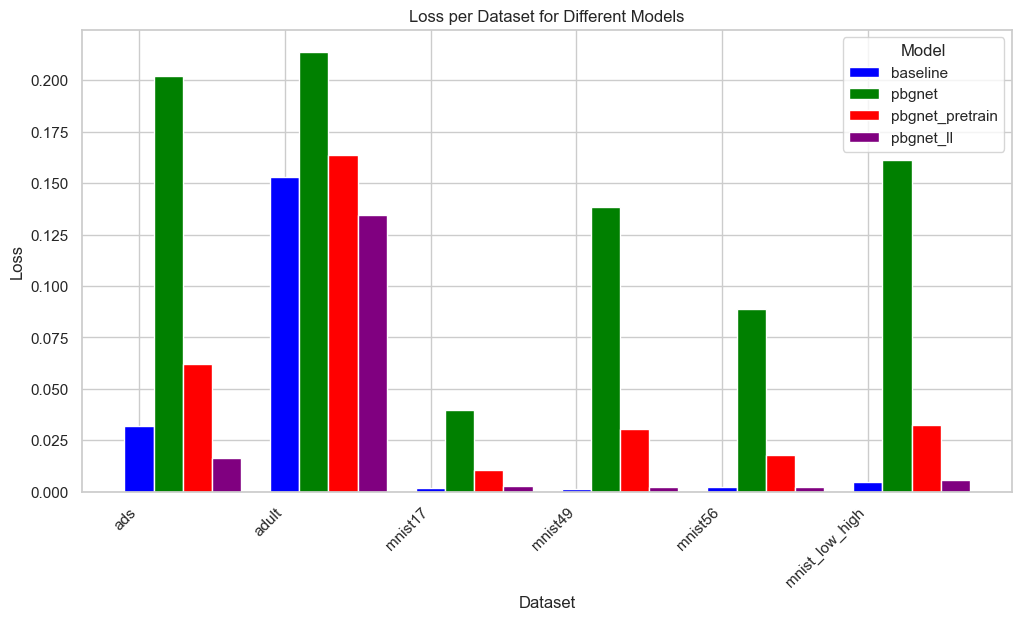

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = log_df

# Extract relevant columns
datasets = data["dataset_name"].unique()
models = data["network"].unique()

# Create a plot
plt.figure(figsize=(12, 6))

# Define color mapping for models
colors = {
    "baseline": "blue",
    "pbgnet": "green",
    "pbgnet_pretrain": "red",
    "pbgnet_ll": "purple",
}

# Bar width
bar_width = 0.2

# Plot bars for each dataset
for i, dataset in enumerate(datasets):
    subset = data[data["dataset_name"] == dataset]
    for j, model in enumerate(models):
        model_data = subset[subset["network"] == model]
        if not model_data.empty:
            plt.bar(i + j * bar_width, model_data["loss"].values[0], width=bar_width, 
                    color=colors[model], label=model if i == 0 else "")

# Labels and title
plt.xticks(range(len(datasets)), datasets, rotation=45, ha="right")
plt.xlabel("Dataset")
plt.ylabel("Loss")
plt.title("Loss per Dataset for Different Models")
plt.legend(title="Model")

# Show the plot
plt.show()


In [ ]:
log_df_pivoted["loss"][["pbgnet", "pbgnet_pretrain", "baseline", "pbgnet_ll"]]

network,pbgnet,pbgnet_pretrain,baseline,pbgnet_ll
dataset_name,,,,
ads,0.202276,0.061891,0.032200,0.016269
adult,0.213754,0.163497,0.152987,0.134561
mnist17,0.039725,0.010623,0.001868,0.002634
mnist49,0.138324,0.030394,0.001573,0.002243
mnist56,0.088990,0.018012,0.002281,0.002291
mnist_low_high,0.161252,0.032501,0.004929,0.005569


**Performance on the test sets**

In [30]:
test_mean_df_pivoted["loss"][["pbgnet", "pbgnet_pretrain", "baseline", "pbgnet_ll"]]

network,pbgnet,pbgnet_pretrain,baseline,pbgnet_ll
dataset_name,,,,
ads,0.202098,0.061951,0.047262,0.019704
adult,0.213728,0.163502,0.159447,0.135597
mnist17,0.039703,0.010593,0.003533,0.003316
mnist49,0.138283,0.030354,0.001779,0.002990
mnist56,0.089013,0.018021,0.004185,0.004880
mnist_low_high,0.161462,0.032503,0.006026,0.007203


### **Comments**

- **Performance Comparison**: The **Baseline** and **PBGNet_LL** models outperform the other PBGNet variants. The **PBGNet_Pretrain** model shows competitive performance relative to PBGNet, but PBGNet itself generally lags behind. However, despite this performance gap, the **PBGNet-based models provide theoretical guarantees on generalization error**, which is a crucial advantage.

- **Theoretical Considerations**: When attempting to compute the bound for **PBGNet_LL** using **Cantoni's bound**, the resulting bounds are **non-informative**. This is expected, as the loss function in PBGNet_LL was not explicitly designed to minimize the KL term directly.

- **Overfitting Analysis**: The **PBGNet and PBGNet_Pretrain models exhibit close values between training and test performance**, suggesting they generalize well and are robust to overfitting. In contrast, **PBGNet_LL shows a more significant gap between training and test losses**, hinting that incorporating the bound in the learning process might contribute to better robustness. However, **Baseline and PBGNet_LL models could be prone to overfitting**, as their training loss is particularly low. 

- To further investigate overfitting, we will verify this hypothesis for the **ADS dataset** in the next analysis.


### **KL diveregence analysis**

In [44]:
# KL divergence value for pbnet_ll, pbnet and pbnet_pretrain
log_df_pivoted["kl"][["pbgnet", "pbgnet_pretrain", "pbgnet_ll"]]

network,pbgnet,pbgnet_pretrain,pbgnet_ll
dataset_name,,,
ads,27.552610,0.029427,1.174388e+04
adult,227.492050,0.053519,1.007689e+04
mnist17,164.368195,0.618098,4.282008e+06
mnist49,305.726746,1.476189,1.051055e+06
mnist56,192.682068,0.709383,9.248104e+05
mnist_low_high,1311.210083,0.536907,5.072012e+07


In [41]:
# Cantoni's Bound for pbnet_ll
test_mean_df_pivoted["bound"][["pbgnet_ll"]]

network,pbgnet_ll
dataset_name,
ads,0.999639
adult,0.560325
mnist17,1.000000
mnist49,1.000000
mnist56,1.000000
mnist_low_high,1.000000


These results confirms the previous insight.

### **Overfitting Analysis**  

- The **PBGNet and PBGNet_Pretrain models** exhibit very close values between test and training performance, suggesting that they generalize well and are less prone to overfitting.  
- In contrast, **PBGNet_LL shows a larger gap between training and test performance**, which indicates a potential **robustness to overfitting** when the bound is actively involved in the learning process.  

To verify this we plot the train, test evolution of the loss for each trainig epoch

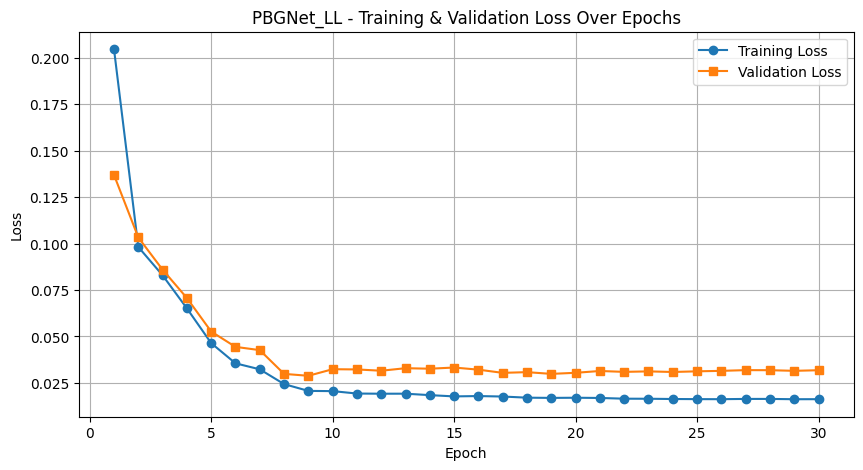

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the base directory
base_path = r"D:\dichotomize-and-generalize-master\results\final_results\ads"

# Dictionary to store DataFrames with folder names as keys
folder_dataframes = {}

# Iterate over subdirectories inside base_path
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    
    if os.path.isdir(folder_path):  # Check if it's a folder
        log_tsv_path = os.path.join(folder_path, "log.tsv")  # Expected log file path
        
        if os.path.exists(log_tsv_path):  # Check if log.tsv exists in the folder
            try:
                df = pd.read_csv(log_tsv_path, sep="\t")  # Load TSV file into DataFrame
                folder_dataframes[folder] = df  # Store with folder name as key
                # print(f"Loaded: {log_tsv_path} ({df.shape[0]} rows, {df.shape[1]} cols)")
            except Exception as e:
                print(f"Error loading {log_tsv_path}: {e}")
        else:
            print(f"No log.tsv file found in {folder_path}")

# Initialize variables
pbgnet_ll_df = None

# Assign the correct dataframes from the folder_dataframes dictionary
for key in folder_dataframes.keys():
    if "pbgnet_ll" in key:
        pbgnet_ll_df = folder_dataframes[key]
    
# Function to plot loss and bound evolution
def plot_loss_and_bound(df, title_prefix, is_bound=True):
    if df is not None and all(col in df.columns for col in ["epoch", "loss", "val_loss", "bound"]):
        epochs = df["epoch"]
        train_loss = df["loss"]
        val_loss = df["val_loss"]
        bound = df["bound"]

        # Plot Training & Validation Loss
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_loss, label="Training Loss", marker='o')
        plt.plot(epochs, val_loss, label="Validation Loss", marker='s')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{title_prefix} - Training & Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

        if is_bound:

            # Plot Bound Evolution
            plt.figure(figsize=(10, 5))
            plt.plot(epochs, bound, label="Bound", marker='d', color='red')
            plt.xlabel("Epoch")
            plt.ylabel("Bound")
            plt.title(f"{title_prefix} - Bound Evolution Over Epochs")
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print(f"No valid data available for plotting {title_prefix}.")

# Plot for pbgnet_ll if available
plot_loss_and_bound(pbgnet_ll_df, "PBGNet_LL", False)

**Comment**: we can clearly see that the model starts overfitting after the 8 th epoch.

## **Final Conclusions**  

### **1. Performance Evaluation & Theoretical Guarantees**  
- The **Baseline and PBGNet_LL models outperform standard PBGNet models** in terms of empirical performance, with **PBGNet_Pretrain** being relatively competitive compared to **PBGNet**.  
- However, **PBGNet models offer theoretical guarantees on generalization error**, which is a key strength that pure empirical models lack.  
- The study confirms that **PAC-Bayesian generalization bounds provide nonvacuous estimates** when applied to binary activated deep neural networks, as outlined in Letarte et al. (2019).  

### **2. Theoretical Considerations & PAC-Bayesian Bounds**  
- Unlike standard deep learning models, **PBGNet-based models leverage PAC-Bayesian bounds** to ensure robustness in generalization, which is theoretically justified by the work of Germain et al. (2009) and Catoni (2007).  
- The computation of **Cantoni’s bound for PBGNet_LL leads to non-informative bounds**, as the loss function in this case does not explicitly minimize the KL term.  
- This aligns with findings from PAC-Bayesian literature, where **optimizing the KL-divergence term directly influences bound tightness** and generalization guarantees.  

### **3. Overfitting & Generalization Analysis**  
- **PBGNet and PBGNet_Pretrain exhibit similar training and test performance**, indicating **strong generalization** and lower risk of overfitting.  
- **PBGNet_LL shows a larger gap between training and test performance**, suggesting that **incorporating the bound in the learning process may enhance robustness to overfitting**.   

### **4. Key Takeaways & Future Work**  
- **The trade-off between empirical performance and theoretical generalization guarantees is evident.**  
- While **Baseline and PBGNet_LL models achieve lower empirical loss, PBGNet models provide strong theoretical insights into generalization**.  
- Future work should explore:  
  - **Improving bound computation for PBGNet_LL** to yield more informative generalization estimates.  
  - **Investigating explicit KL-term minimization** to see its direct effect on learning stability.  
  - **Extending the PAC-Bayesian approach to multi-class classification** and convolutional networks for broader applicability.  

### **Final Thought**  
This work aligns with recent advancements in PAC-Bayesian deep learning, confirming that **integrating theoretical guarantees into the training process can lead to better generalization performance**. The **PBGNet framework represents a promising approach to balancing empirical success with mathematical rigor**, paving the way for more robust and theoretically justified deep learning architectures.

